In [8]:
!wget -nc -q https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
!wget -nc -q https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import geopy.distance
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

## Reading and converting data format

We start by reading the airports file to a pandas Dataframe.

In [10]:
airportsDF = pd.read_csv('airports.dat', header=None, names=['id', 'name', 'city', 'country', 'IATA', 'ICAO', 'lat', 'lon', 'alt', 'timezone', 'DST', 'Tz', 'type', 'source'])

From there, we create a directed graph and add all the airports as nodes to it (except airports with no IATA identifier, which are ignored).
This is because we will use this identifiers later to associate this data with the routes data.

In [11]:
G = nx.DiGraph()

for index, row in airportsDF.iterrows():
    if row['IATA'] == '\\N':
        continue
    G.add_node(row['IATA'], pos=(row['lat'],row['lon']))

Our nodes are identified by their IATA identifiers and have a corresponding position (corresponding to their real geographic location) 

In [12]:
print(G.nodes['LIS'])

{'pos': (38.7813, -9.13592)}


So far we have a graph with nodes but no edges

In [13]:
print("Node count: " + str(len(G.nodes)))
print("Edge count: " + str(len(G.edges)))

Node count: 6072
Edge count: 0


Now we read the routes data and add each one as an edge of our graph previously created
This routes are directed, meaning that if an airline operates services from A to B and from B to A, both A-B and B-A are listed as diferent edges
We also add weight to this edges, the distance between airports in km.

In [14]:
routesDF = pd.read_csv('routes.dat', header=None, names=['airline', 'airlineID', 'source', 'sourceID', 'dest', 'destID', 'codeshare', 'stops', 'equipment'])

for index, row in routesDF.iterrows():
    if(row['source'] not in G.nodes or row['dest'] not in G.nodes):
        continue
    dist = geopy.distance.distance((G.nodes[row['source']]['pos']), (G.nodes[row['dest']]['pos'])).km
    G.add_edge(row['source'], row['dest'], weight=dist)

As an example, we take a route from Lisbon to Cologne to show this representation.

In [15]:
print(list(G.edges('LIS',data=True))[0])

('LIS', 'CGN', {'weight': 1852.3023399687195})


We can now see that our graph has nodes and edges.

In [16]:
print("Node count: " + str(len(G.nodes)))
print("Edge count: " + str(len(G.edges)))

Node count: 6072
Edge count: 37042


## Cleaning data

We now "clean" our graph, removing the nodes which have either 0 incoming flights or 0 outgoing flights (or both).
We iterate the graph until no more changes are made. This is because after removing one node, another one might lose the only incoming or outgoing route it had previously.

In [17]:
i=0
while i == 0:
  i = 1
  H = G.copy()
  for node in H.in_degree:
    if node[1] == 0:
      i = 0
      G.remove_node(node[0])
      
  H = G.copy()
  for node in H.out_degree:
    if node[1] == 0:
      i = 0
      G.remove_node(node[0])

We end up with a significant reduction in nodes and lose barely any edges, obtaining what we wanted and removing unutilized airports from the network.

In [18]:
print("Node count: " + str(len(G.nodes)))
print("Edge count: " + str(len(G.edges)))

Node count: 3216
Edge count: 36996


## Analysing network metrics

We can also see that the Frankfurt airport, Charles de Gaulle airport in Paris and Amesterdam are the nodes with the highest degree, with around 450 incoming or outgoing routes each.

In [19]:
nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
print(nodes[0:3])

[('FRA', 477), ('CDG', 469), ('AMS', 463)]


We also see that the majority of airports have a very low degree, resulting in a near zero density in our graph.

In [20]:
# Graph density
nx.density(G)

0.003578143497133307

With the degree distribution we verify that almost 800 airports (of the near 3000) have a degree of only 2, meaning only one incoming route and one outgoing one.

Text(0.5, 0, 'Degree Value')

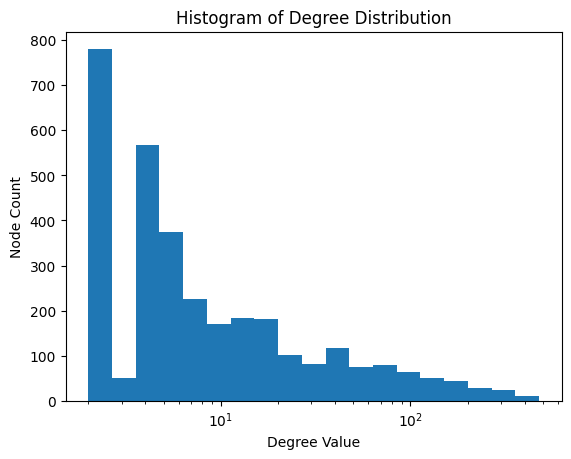

In [21]:
# Degree Distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=np.logspace(np.log10(2),np.log10(max(degrees)), 20))
plt.xscale("log")
plt.title("Histogram of Degree Distribution")
plt.ylabel("Node Count")
plt.xlabel("Degree Value")


The comulative distribution also proves this point.

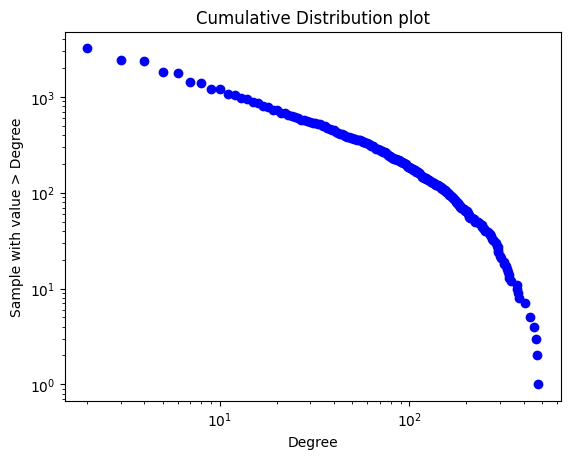

In [22]:
import collections

degrees = [G.degree(n) for n in G.nodes()]
degree_sequence = sorted(degrees, reverse=True) # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(cnt)
plt.loglog(deg, cs, 'bo')
plt.title("Cumulative Distribution plot")
plt.ylabel("Sample with value > Degree")
plt.xlabel("Degree")
plt.show()

## Degree centrality

We now calculate some metrics of the network, starting with the degree centrality
As seen before, Frankfurt is the airport with the highest degree.
A military base in Greenland is the one of the many airports with only degree 2, resulting in a low degree centrality.

In [23]:
# compute graph degree centrality
dc = nx.degree_centrality(G)

max_dc = max(dc, key=dc.get)
print("Airport with the max degree centrality: " + max_dc)
print("Value: " + str(dc[max_dc]))

min_dc = min(dc, key=dc.get)
print("Airport with the min degree centrality: " + min_dc)
print("Value: " + str(dc[min_dc]))

Airport with the max degree centrality: FRA
Value: 0.14836702954898912
Airport with the min degree centrality: THU
Value: 0.0006220839813374805


## Eigenvector centrality

For the eigenvector centrality we get that Amsterdam airport has the highest value.

In [24]:
# compute eigen vector centrality
ec = nx.eigenvector_centrality(G)

max_ec = max(ec, key=ec.get)
print("Airport with the max eigenvector centrality: " + max_ec)
print("Value: " + str(ec[max_ec]))

min_ec = min(ec, key=ec.get)
print("Airport with the min eigenvector centrality: " + min_ec)
print("Value: " + str(ec[min_ec]))

Airport with the max eigenvector centrality: AMS
Value: 0.16594781190242047
Airport with the min eigenvector centrality: YWH
Value: 1.6652353161757847e-34


## Closeness centrality

For the closeness centrality we get that Frankfurt airport has the highest value.

In [25]:
# compute closeness centrality
cc = nx.closeness_centrality(G)

max_cc = max(cc, key=cc.get)
print("Airport with the max closeness centrality: " + max_cc)
print("Value: " + str(cc[max_cc]))

min_cc = min(cc, key=cc.get)
print("Airport with the min closeness centrality: " + min_cc)
print("Value: " + str(cc[min_cc]))

Airport with the max closeness centrality: FRA
Value: 0.4090005513816514
Airport with the min closeness centrality: YWH
Value: 0.00031104199066874026


## Betweenness centrality

For the betweenness centrality we get that Charles de Gaulle airport has the highest value.

In [26]:
# compute betweenness centrality
bc = nx.betweenness_centrality(G)

max_bc = max(bc, key=bc.get)
print("Airport with the max betweenness centrality: " + max_bc)
print("Value: " + str(bc[max_bc]))

min_bc = min(bc, key=bc.get)
print("Airport with the min betweenness centrality: " + min_bc)
print("Value: " + str(bc[min_bc]))

Airport with the max betweenness centrality: CDG
Value: 0.06303816371835555
Airport with the min betweenness centrality: GKA
Value: 0.0


## Page rank

For the page rank we get that Charles de Gaulle airport has the highest value.

In [27]:
# compute pagerank
pr = nx.pagerank(G)

max_pr = max(pr, key=pr.get)
print("Airport with the max page rank: " + max_pr)
print("Value: " + str(pr[max_pr]))

min_pr = min(pr, key=pr.get)
print("Airport with the min page rank: " +min_pr)
print("Value: " + str(pr[min_pr]))

Airport with the max page rank: CDG
Value: 0.00935746629232145
Airport with the min page rank: PRI
Value: 4.709715406155476e-05


## Clustering

For the clustring we get that Goroka airport has the highest value. 
### TODO: check why

In [28]:
# compute clustering coefficient
cl = nx.clustering(G)

max_cl = max(cl, key=cl.get)
print("Airport with the max clustering: " + max_cl)
print("Value: " + str(cl[max_cl]))

min_cl = min(cl, key=cl.get)
print("Airport with the min clustering: " + min_cl)
print("Value: " + str(cl[min_cl]))

Airport with the max clustering: GKA
Value: 1.0
Airport with the min clustering: THU
Value: 0


### Strongly connected components

Using the networkx function to get us the strongly connected components, we verify that out graph has 7.
One of them has almost every node and the rest are small, due to this we'll only consider the biggest one in some future steps.

In [29]:
# generate strongly connected components
sccs = nx.strongly_connected_components(G)
print([len(Gc) for Gc in sccs])

sccs = nx.strongly_connected_components(G)
sccs_graphs = (G.subgraph(c) for c in sccs)

largest_scc = list(sccs_graphs)[0]
print(len(largest_scc))

[3190, 10, 4, 4, 2, 2, 4]
3190


Before having a strongly connected component, calculating the average shortest path and the diameter of the network was not possible since there were some infinite distances, now we can do it.
## TODO remove nodes with low degree and check this metrics

In [30]:
# average shortest path
#TODO: add weights

#avg_path_length = nx.average_shortest_path_length(largest_scc, weight='weight')
#sprint(avg_path_length)

In [31]:
#nx.diameter(largest_scc)

## Plotting the data on a map

We can now plot each airport in a map and give each dot some coloring and size according to its centrality.
Having created a function that receives which centrality to be used, the list of nodes to be plotted and a threshold (values lower that this threshold won't be displayed), we can plot the maps for each of the centralities calculated before.

In [64]:
def plotMap(label, centrality_dict, list_nodes, threshold):
    newAirportsDF = pd.DataFrame(columns=['id', 'name', 'city', 'country', 'IATA', 'ICAO', 'lat', 'lon', 'alt', 'timezone', 'DST', 'Tz', 'type', 'source'])
    
    # get max and min to normalize
    max_value = max(centrality_dict.values())
    min_value = min(centrality_dict.values())

    # from the list given, add the nodes that have a higher centrality value than the threshold
    for node in list_nodes:
        if(centrality_dict[node] > threshold):
            x = airportsDF.loc[airportsDF['IATA'] == node]
            x_norm = (centrality_dict[node] - min_value) / (max_value - min_value)
            x['color'] = centrality_dict[node]
            x['markersize'] = (x_norm **3) * 150
            newAirportsDF = pd.concat([newAirportsDF, x])

    geometry = [Point(xy) for xy in zip(newAirportsDF['lon'], newAirportsDF['lat'])]
    gdf = GeoDataFrame(newAirportsDF, geometry=geometry)

    # #this is a simple map that goes with geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(column="color", ax=world.plot(figsize=(20, 12)), marker='o', markersize="markersize", cmap='rainbow', 
            legend=True, legend_kwds={"label": label, "orientation": "horizontal"})

In [65]:
# Ignores a warning that is not worrying in this case and creates a lot of noisy output
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [66]:
D = G.copy()
print(len(D.nodes))
print(len(D.edges))
i=0
while i == 0:
  i = 1
  H = D.copy()
  for node in H.in_degree:
    if node[1] < 5:
      i = 0
      D.remove_node(node[0])
      
  H = D.copy()
  for node in H.out_degree:
    if node[1] < 5:
      i = 0
      D.remove_node(node[0])

print(len(D.nodes))
nodes = sorted(D.degree, key=lambda x: x[1])
print(nodes)
print(len(D.edges))

3216
36996
1055
[('YMM', 10), ('YXU', 10), ('LDY', 10), ('KOI', 10), ('LSI', 10), ('BOO', 10), ('MOL', 10), ('VXO', 10), ('RLG', 10), ('GBE', 10), ('VGO', 10), ('PIS', 10), ('LDE', 10), ('ETZ', 10), ('PGF', 10), ('TUF', 10), ('KVA', 10), ('CUF', 10), ('PEG', 10), ('GZT', 10), ('ASR', 10), ('GIB', 10), ('ACA', 10), ('LMM', 10), ('OAX', 10), ('QRO', 10), ('TGZ', 10), ('TAM', 10), ('ZCL', 10), ('ZIH', 10), ('GGT', 10), ('VLI', 10), ('WLG', 10), ('HAS', 10), ('ZAH', 10), ('ROR', 10), ('IBR', 10), ('OIT', 10), ('KMJ', 10), ('AXT', 10), ('PPS', 10), ('NVT', 10), ('BLA', 10), ('SLU', 10), ('MJZ', 10), ('BQS', 10), ('SIP', 10), ('PEE', 10), ('REN', 10), ('IXB', 10), ('ATQ', 10), ('PBH', 10), ('HDY', 10), ('MDC', 10), ('BTU', 10), ('LGK', 10), ('ISA', 10), ('KTA', 10), ('GNV', 10), ('BFL', 10), ('SHV', 10), ('IAG', 10), ('PHF', 10), ('SWF', 10), ('PBG', 10), ('MOB', 10), ('MFE', 10), ('ILM', 10), ('VPS', 10), ('PKN', 10), ('ELM', 10), ('BUS', 10), ('RFD', 10), ('PPT', 10), ('BIS', 10), ('DVO', 

## Degree centrality map

/tmp/ipykernel_641/2796678064.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newAirportsDF = pd.concat([newAirportsDF, x])
/tmp/ipykernel_641/2796678064.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


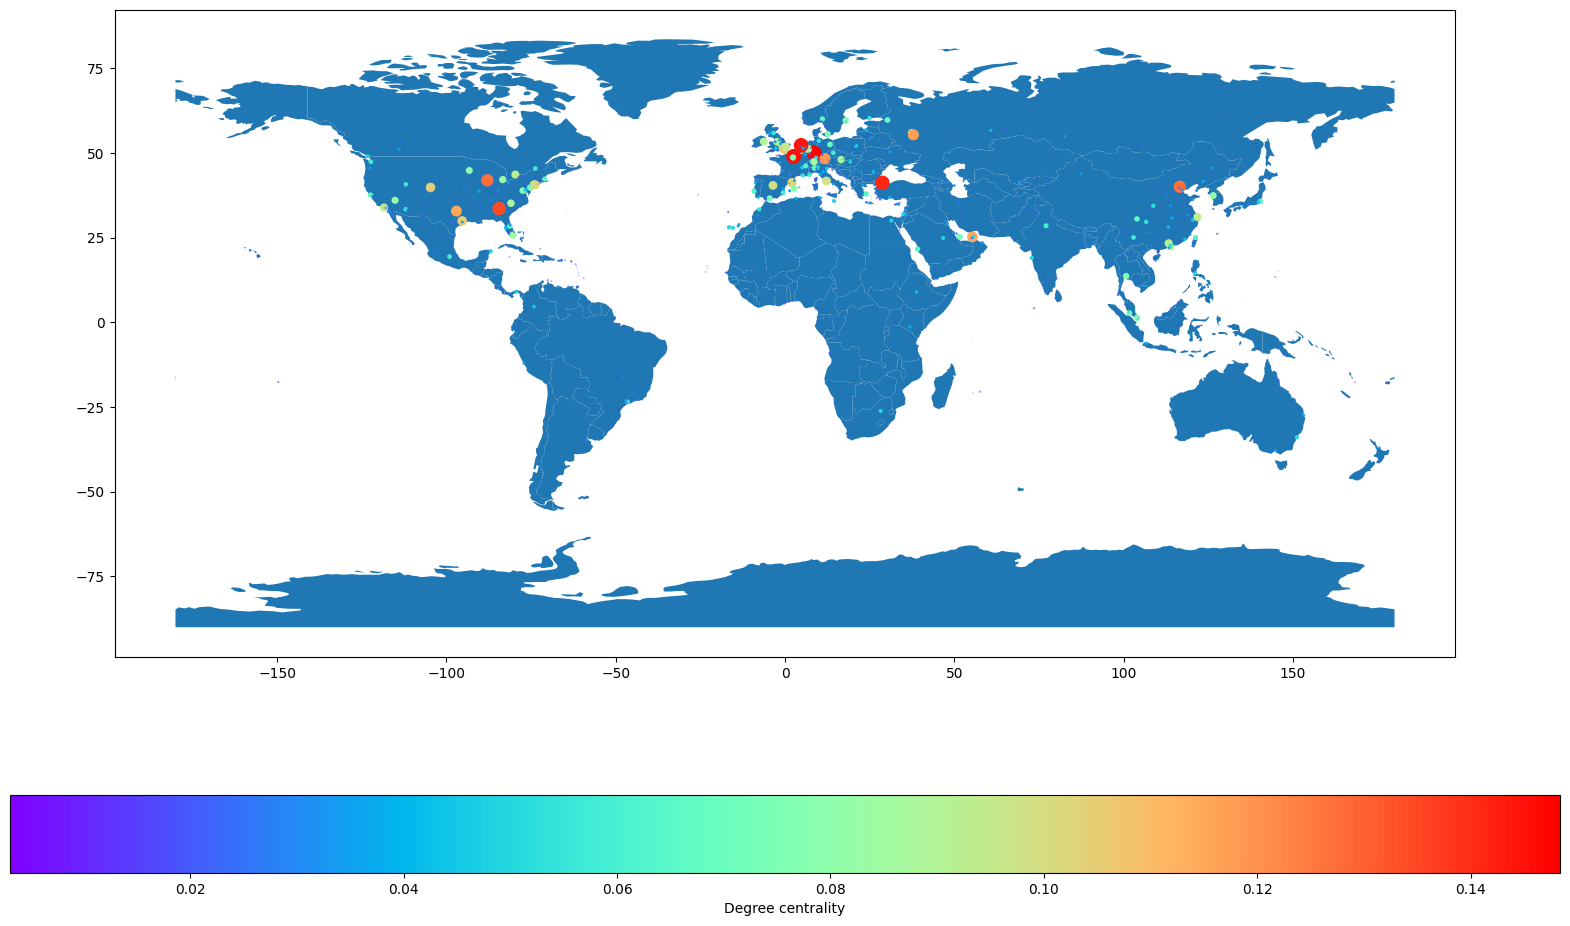

In [67]:
plotMap("Degree centrality", dc, D.nodes, 0)

## Eigenvector centrality map

/tmp/ipykernel_641/2796678064.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newAirportsDF = pd.concat([newAirportsDF, x])
/tmp/ipykernel_641/2796678064.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


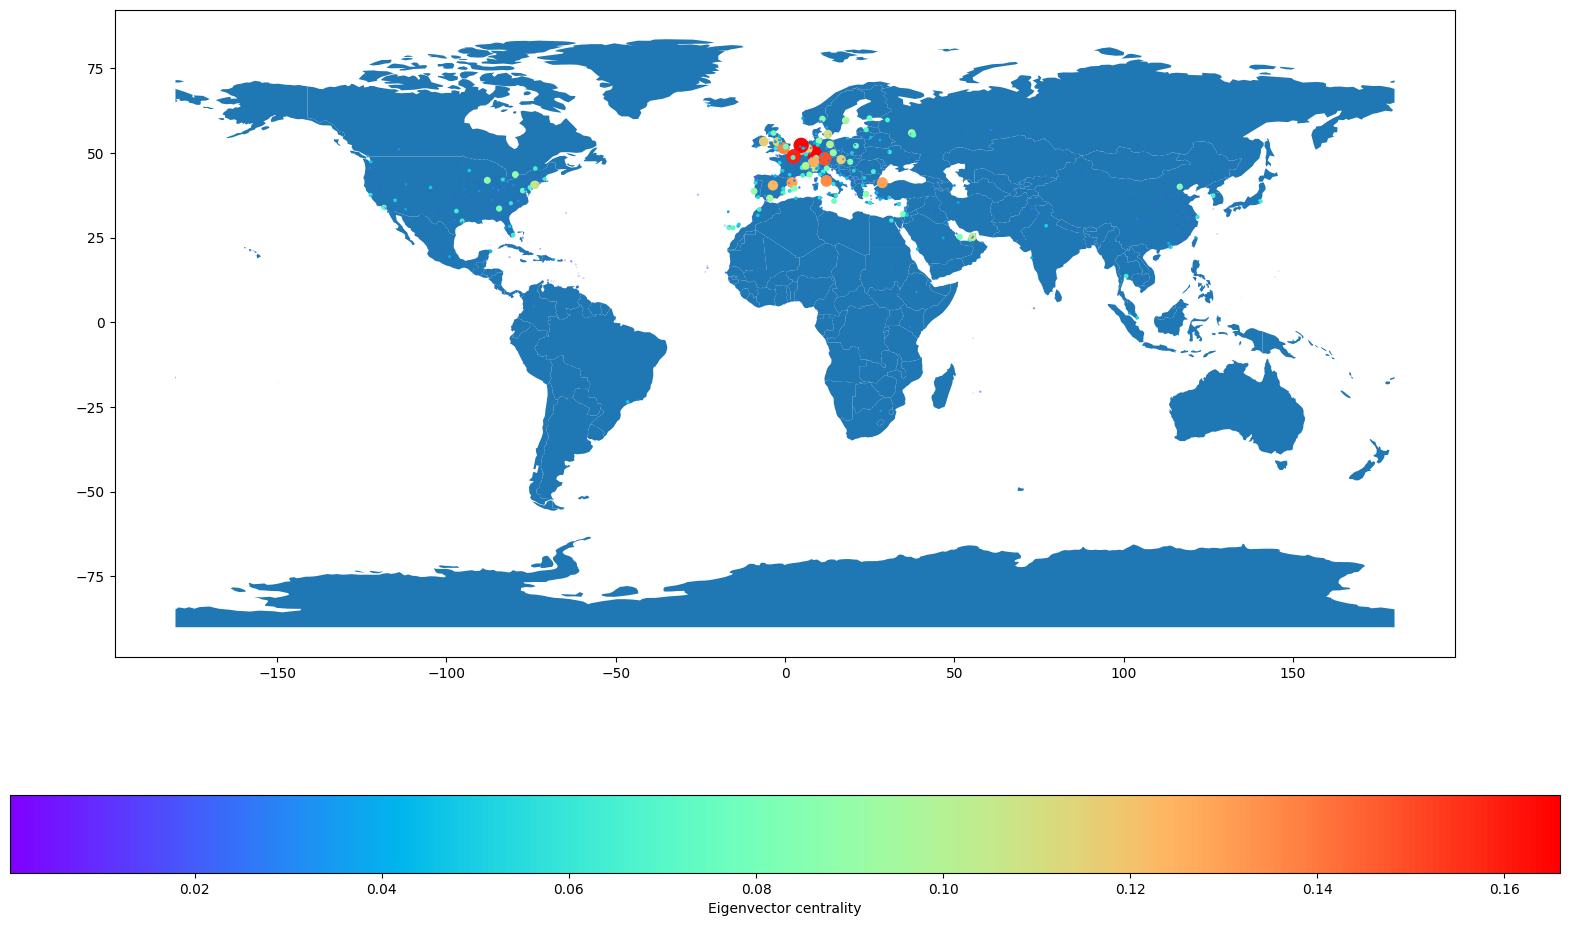

In [68]:
plotMap("Eigenvector centrality", ec, D.nodes, 0)

## Closeness centrality map

/tmp/ipykernel_641/3070612812.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newAirportsDF = pd.concat([newAirportsDF, x])
/tmp/ipykernel_641/3070612812.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


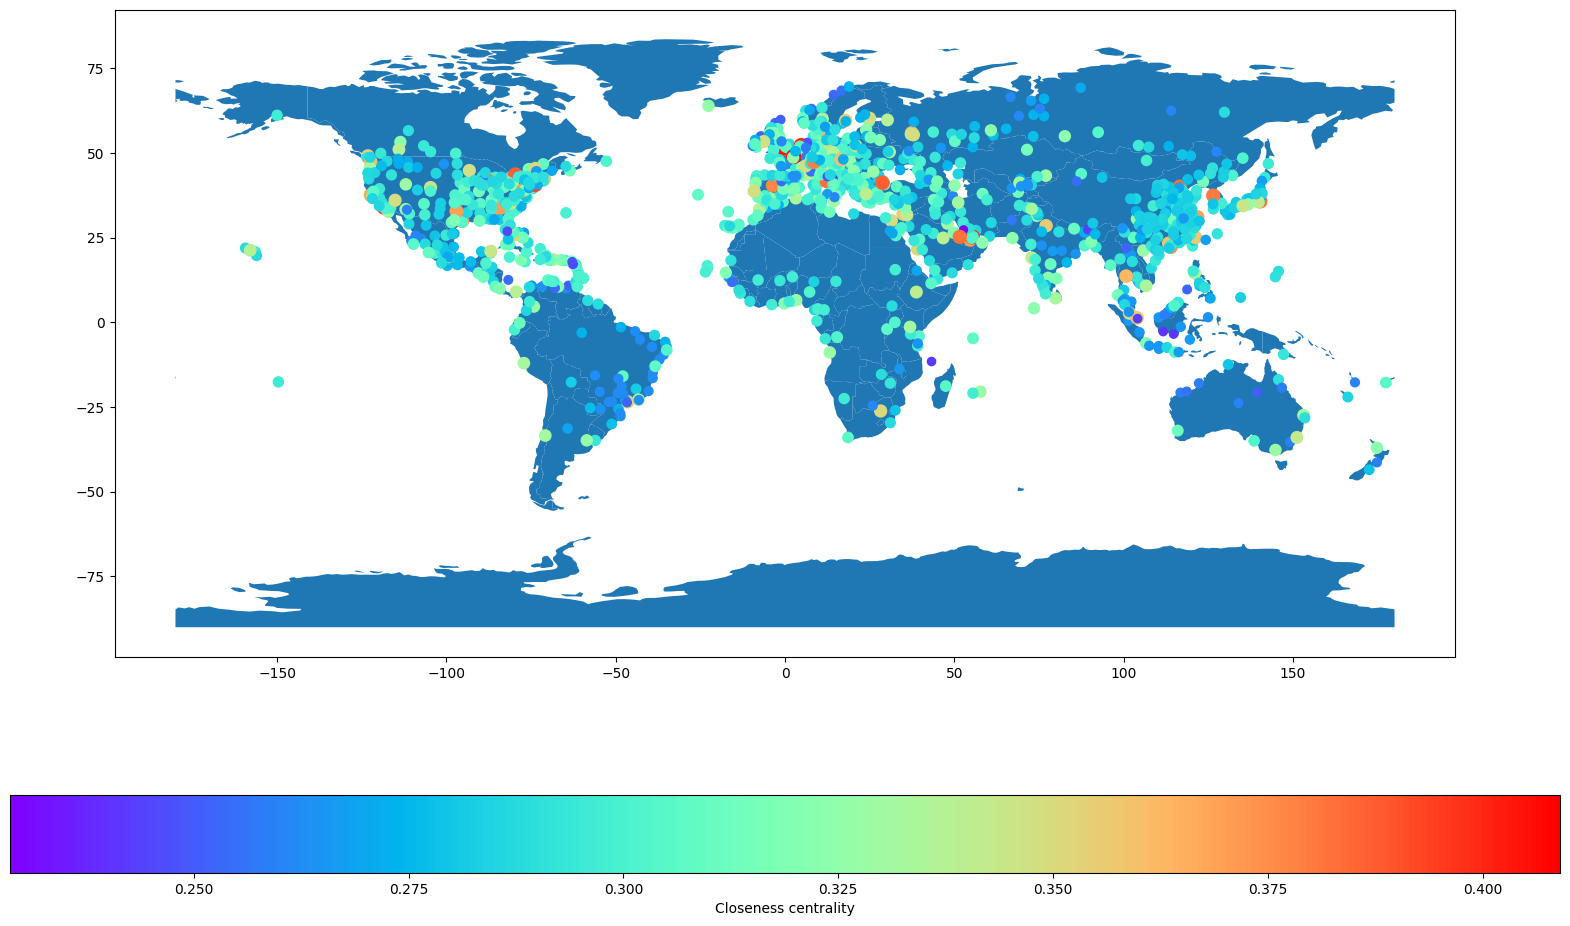

In [61]:
plotMap("Closeness centrality", cc, D.nodes, 0)

## Betweenness centrality map

/tmp/ipykernel_641/3070612812.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newAirportsDF = pd.concat([newAirportsDF, x])
/tmp/ipykernel_641/3070612812.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


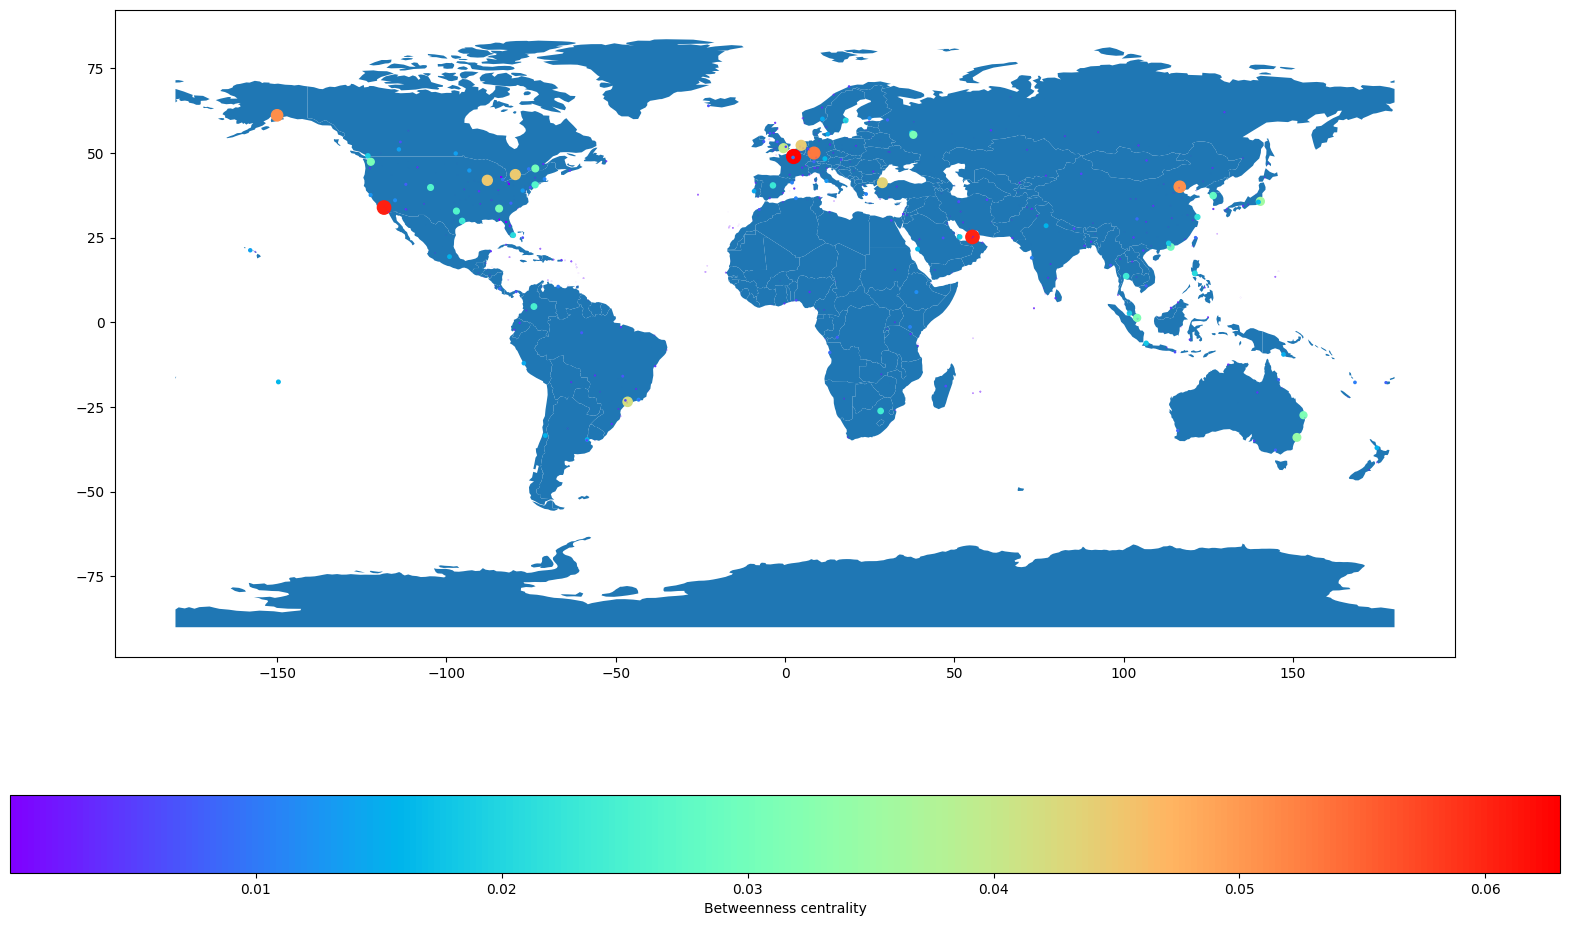

In [62]:
plotMap("Betweenness centrality", bc, D.nodes, 0)

## Page rank map

/tmp/ipykernel_641/3070612812.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newAirportsDF = pd.concat([newAirportsDF, x])
/tmp/ipykernel_641/3070612812.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


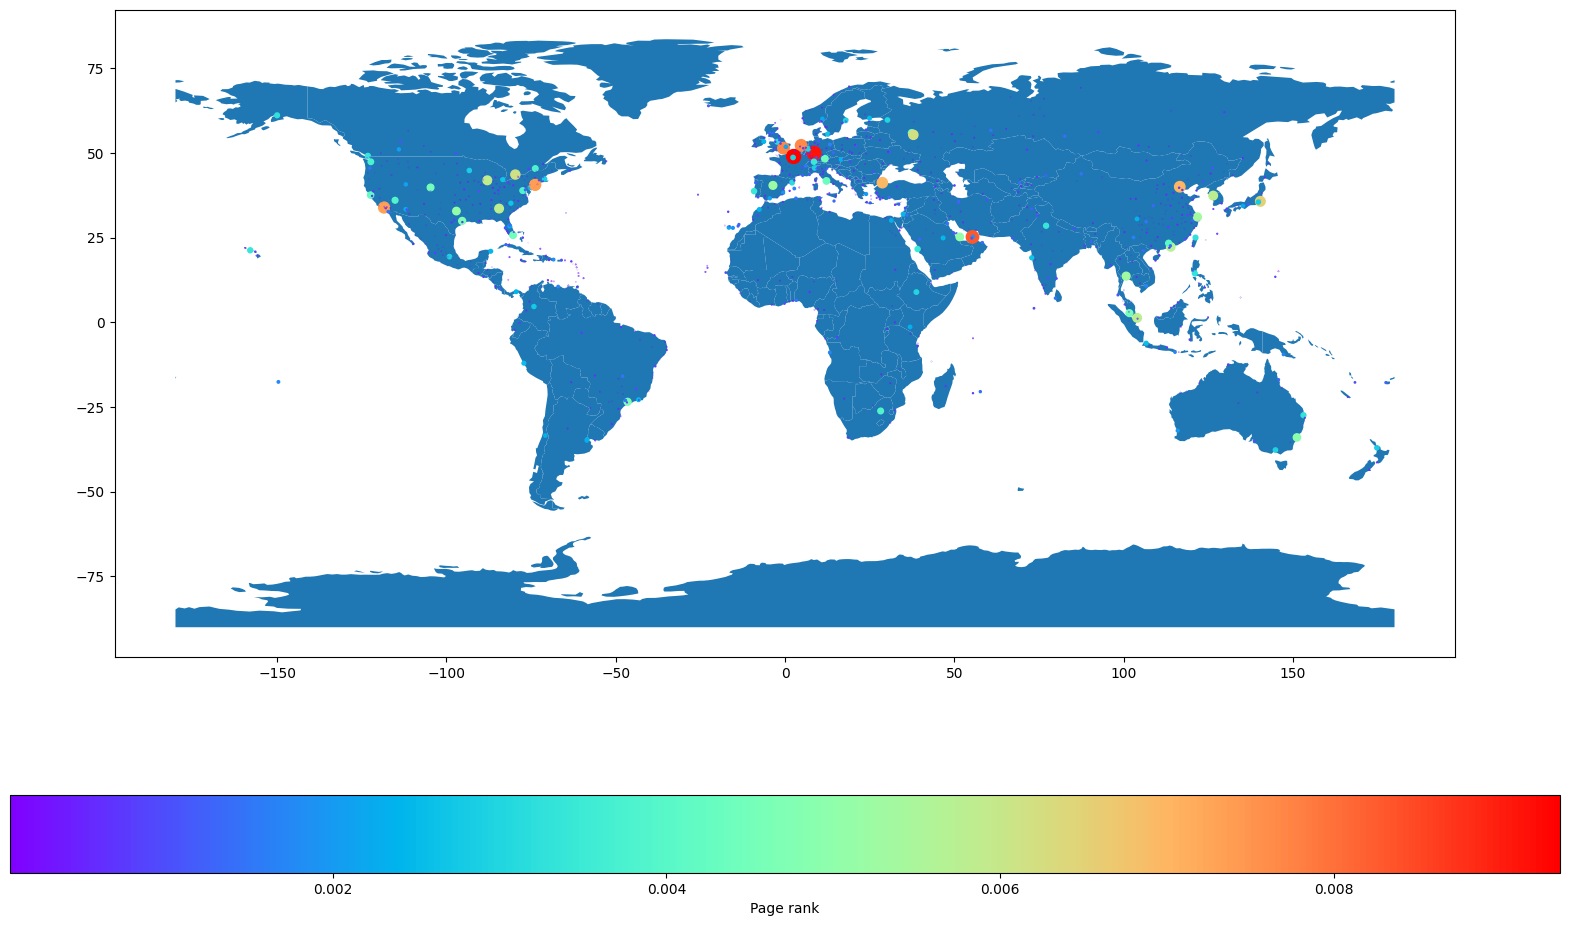

In [63]:
plotMap("Page rank", pr, D.nodes, 0)